In [2]:
import numpy as np
import pandas as pd
import pyodbc
import sqlalchemy
import sqlite3
from subprocess import check_output
import os
from IPython.core.display import Image, display

from sqlalchemy import create_engine
engine = create_engine('sqlite:////...', echo=False)

# PRACTICEs

This final chapter ends with some database management-related topics. You will learn how to grant database access based on user roles, how to partition tables into smaller pieces, what to keep in mind when integrating data, and which DBMS fits your business needs best.

## 1. Database roles and access control

#### Granting & revoking access to a view
Reminder from [chapter3_Section_2](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/SQL%20practices/Track:%20SQL%20for%20Database%20Administrators/Course2:%20Database%20Design/database-views.ipynb)

**Syntax**

            GRANT privilege(s) or REVOKE privilege(s)
            ON object
            TO role FROM role

**Explains.**
> **Privilege(s):** `SELECT, INSERT, UPDATE, DELETE, etc.`

> **Object:** `table, view, schema`

> **Roles :** a database user or a group of database users

**Example.** Using Revoke

    REVOKE INSERT
    ON films
    FROM db_users


#### DATABASE ROLES.

> Manages database access permissions,.

> A database roles is an entity that contain information that :

>> Defines the role priveleges; E.g, `Can you login? Can you create database, Can you write to table, etc` 

>> Interact with the client authentication systems: e.g `author`.

> Roles can be assigned to one or more users

> Roles are global across a database cluster installation.

### Create a role.
#### Empty role.
For example

        CREATE ROLE data_analyst;
#### Role with some attributes sets
For example

        -- 1) For interns
        CREATE ROLE intern WITH PASSWORD 'PasswordForIntern' VALID UNTIL '2021-01-01';
        
        -- 2) For admins
        CREATE ROLE admin CREATEDB;
        
        ALTER ROLE admin CREATEROLE;
#### GRANT & REVOKE previleges from roles.
**`Grant update on ... to ...`**

            GRANT UPDATE ON ratings TO data_analyst;
**`Revoke update on ... from ...`**

            REVOKE UPDATE ON ratings FROM data_analyst;
The `available previleges` in **`PostgreSQL`** are:

                SELECT, INSERT, UPDATE, DELETE, TRUNCATE, REFERENCES, TRIGGER, CREATE,
                CONNECT, TEMPORARY, EXCUTE, USAGE

#### USERS & GROUPS (are both roles)

A role is an entity that can function as a user and / or a group.

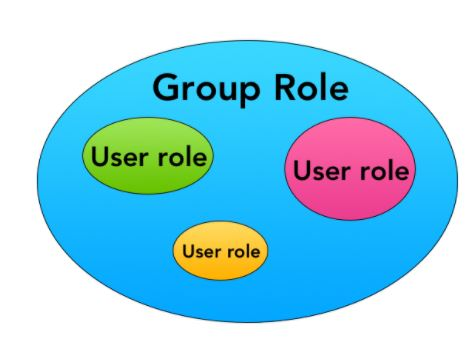

In [3]:
## hidden

#### Examples: Users & groups are both roles.
> **Group role.**

            CREATE ROLE data_analyst
> **Users role**

            CREATE ROLE intern WITH PASSWORD 'PasswordForIntern' VALID UNTIL '2021-01-01';
            --------------------------------------------------------------------------------
            CREATE ROLE alex WITH PASSWORD 'PasswordForIntern' VALID UNTIL '2021-01-01';
            GRANT data_analyst TO alex;
            REVOKE data_analyst FROM alex;
            
#### COMMON POSTGRESQL ROLEs

| Role | Allowed Access |
|-|-|
| pg_read_all_settings | Read all configuration variables, even those normally visible only to superusers. |
| pg_read_all_stats | Read all `pg_stat_*` views and uses various statistic related extensions, even though normally visible only to superusers. |
| pg_signal_backend | Send signals to other backends (e.g.,cancel query, terminate) |
| more ... | more ... |

#### BENIFITs & PITFALLs OF ROLEs.

| **Benifits** | **Pitfalls** |
|-|-|
| Role lives on after users deleted | Sometimes a role gives a specific user too much access. We must to pay attention. |
| Role can be created before user accounts | |
| Save DBAs time| |

#### Summary example

### EXERCISEs
#### Exercise 1.1. Create a role
A database `role` is an entity that contains information that define the role's privileges and interact with the client authentication system. Roles allow you to give different people (and often groups of people) that interact with your data different levels of access.

Imagine you founded a startup. You are about to hire a group of data scientists. You also hired someone named Marta who needs to be able to login to your database. You're also about to hire a database administrator. In this exercise, you will create these roles.

#### Instructions
**Step 1.** Create a role called `data_scientist`.

**SOLUTION.**

                CREATE ROLE data_scientist

**Step 2.** Create a role called marta that has one attribute: the ability to login **`(LOGIN)`**.

**SOLUTION.**

                CREATE ROLE marta LOGIN ;
**Step 3.** Create a role called admin with the ability to create databases **`(CREATEDB)`** and to create roles **`(CREATEROLE)`**.

**SOLUTION.**

                CREATE ROLE admin WITH CREATEDB CREATEROLE
**Comments.** You created a `group role`, `data_scientist`, that you can populate later with whatever access level you deem appropriate. 

>`Marta` can login. 

> The `admin`, whoever holds that `role`, has the ability to create databases and manage roles. 

You now know how to create roles to specify different levels of access for individuals and groups of individuals, which is good database management practice. 

#### Exercise 1.2. GRANT privileges and ALTER attributes
Once roles are created, you grant them specific access control `privileges` on objects, like tables and views. 

Common `privileges` being **`SELECT, INSERT, UPDATE, etc`**.

Imagine you're a cofounder of that startup and you want all of your data scientists to be able to update and insert data in the `long_reviews` view. In this exercise, you will enable those soon-to-be-hired data scientists by granting their role (`data_scientist`) those `privileges`. Also, you'll give `Marta's` role a `password`.

#### Instructions
`Grant` the `data_scientist` role update and insert `privileges` on the `long_reviews` `view`.

Alter `Marta's role` to give her the provided `password`.

**SOLUTION.**

                -- Grant data_scientist update and insert privileges
                GRANT UPDATE, INSERT ON long_reviews TO data_scientist;

                -- Give Marta's role a password
                ALTER ROLE marta WITH PASSWORD 's3cur3p@ssw0rd';
**Comments.**

Noting that if using `CREATE ROLE marta...` then you will get `role "marta" already exists`.

Everyone in the `data_scientist role` (which is currently no one, though you're hiring shortly) is now able to update data and insert data in the `long_reviews view`. 

This view has business-critical data that's updated often so these privileges are key to your startup's success. 

Marta is happy because she has a `password` now, too!

#### Exercise 1.3. Add a user role to a group role
There are two types of roles: user roles and group roles. By assigning a user role to a group role, a database administrator can add complicated levels of access to their databases with one simple command.

For your startup, your search for data scientist hires is taking longer than expected. Fortunately, it turns out that Marta, your recent hire, has previous data science experience and she's willing to chip in the interim. In this exercise, you'll add Marta's user role to the data scientist group role. You'll then remove her after you complete your hiring process.

#### Instructions
Add `Marta's user role` to the data scientist `group role`.

Celebrate! You hired multiple data scientists.

`Remove Marta's user role` from the data scientist `group role`.

**SOLUTION.**

            -- Add Marta to the data scientist group
            GRANT data_scientist TO marta;

            -- Celebrate! You hired data scientists.

            -- Remove Marta from the data scientist group
            REVOKE data_scientist FROM marta;

## 2. Table partitioning

### Why using partition?

| **Problems** | **Reason** | **Solution**|
|-|-|-|
| Queries / updates become slower | E.g., indices dont' fit memory | Split tables into smaller parts (`partitioning`)|

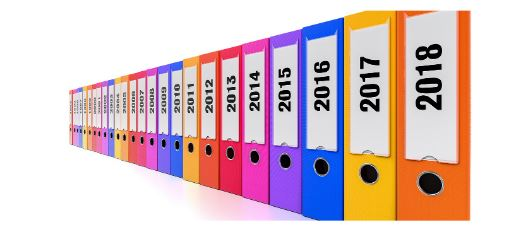

In [4]:
## hidden

### Data modeling refresher
For instance,
> **1. `Conceptual data model`.**

> **2. `Logical data model`.** For partitioning, data model is the same.

> **3. `Physical data model`.** Partitioning is part of data model.
#### VERTICAL PARTITIONING.
***Split table even data fully normalized.***

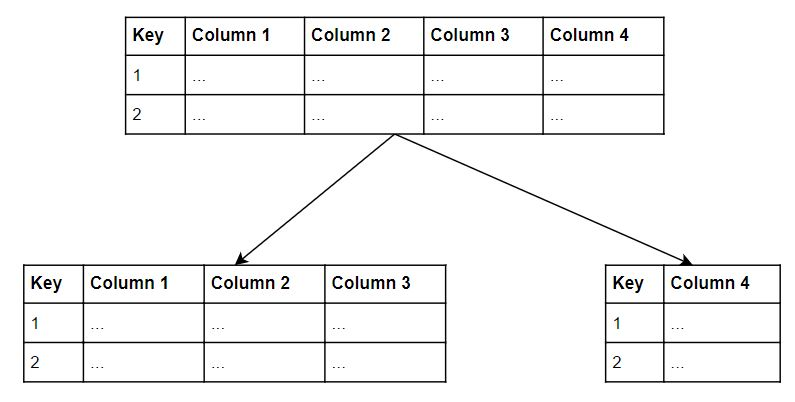

In [5]:
## vertical_partitioning split the database into the sub-data based on columns_spliting

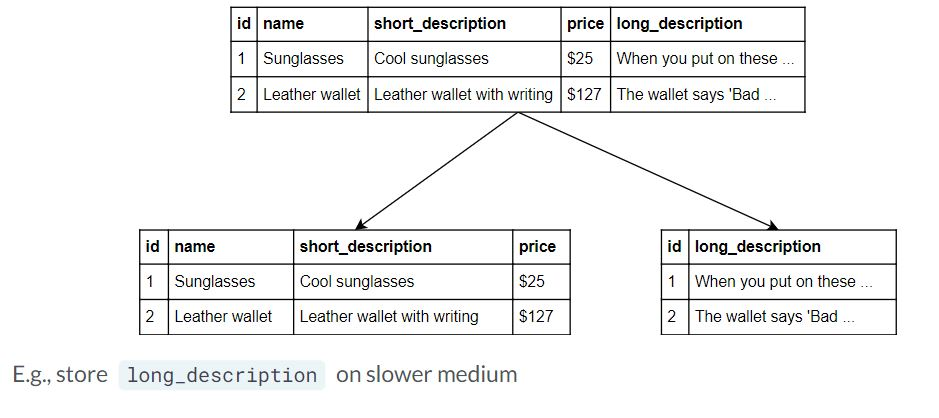

In [6]:
## Example

### HORIZONTAL PARTITIONING

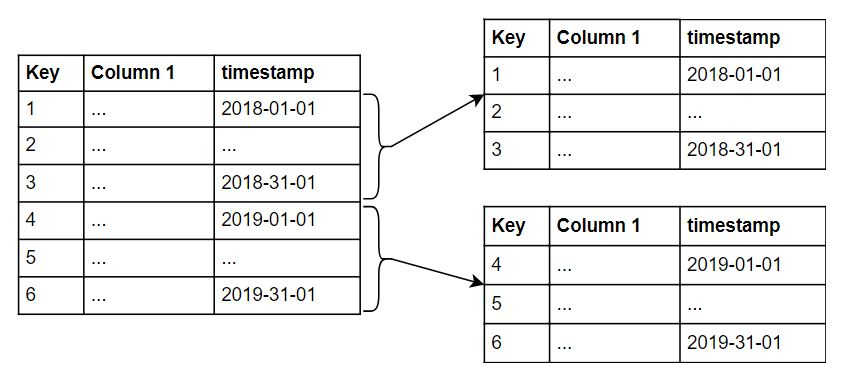

In [7]:
## hidden

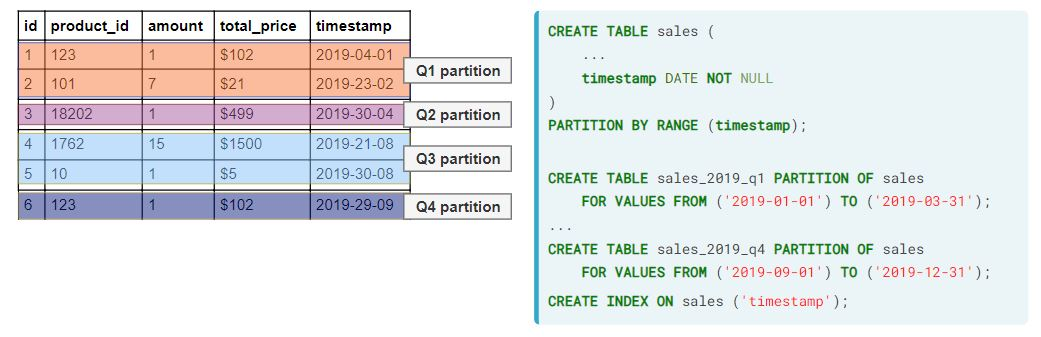

In [8]:
## hidden

### PROS / CONS OF HORIZONTAL PARTITIONING

| **`Pros`** | **`Cons`** |
|-|-|
| Indices of **heavily-used partition** fit in memory | Partitioning **existing table** can be hassle |
| Move to **specific medium: `slower` vs `faster`** | Some **constraints** can not be set |
| Used to both OLAP & OLTP | |

### RELATION TO SHARDING

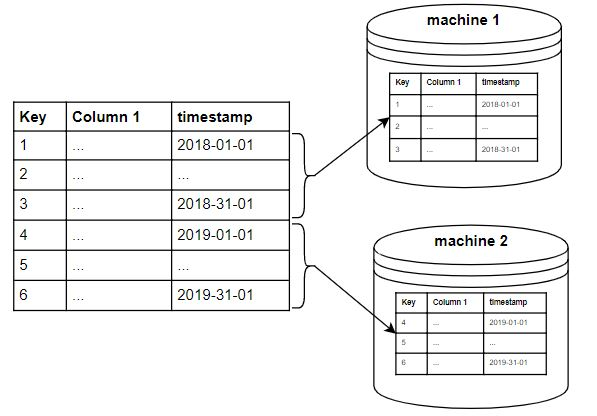

In [9]:
## hidden

### EXERCISE

#### Exercise 1.1. Reasons to partition
> Answer the following question, you saw some very good reasons to use partitioning. However, can you find **which one wouldn't be a good reason to use partitioning?**

A. Improve `data integrity`

B. Save `records` from 2017 or earlier on a `slower medium`

C. Easily extend `partitioning` to `sharding`, and thus making use of `parallelization`

> **Answers & comments!**

**A. Exactly!!!** That's not something you'd use `partitioning` for.

*B. Wrong!!* You could use `horizontal partitioning` to achieve that.

*C. Incorrect!!* Actually, `sharding` is very similar to `horizontal partitioning`.

#### Exercise 2.2. `Partitioning and normalization`
In this section, you saw the differences between the two types of `partitioning`: `vertical` and `horizontal partitioning`. As you'd expect, the names suggest how these different strategies work.

It might be a bit challenging to distinguish `normalization`, which you saw in [previous chapters](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/SQL%20practices/Track:%20SQL%20for%20Database%20Administrators/Course2:%20Database%20Design/database-schemas-and-normalization.ipynb), from `partitioning`.

Can you classify the characteristics in the correct bucket?

**SOLUTION.**

| **`Normalization`** | **`Vertical Partitioning`** | **`Horizontal partitioning`** |
|-|-|-|
| Reduce `redundancy` in `table`| Move specific column to `slower medium`| `Sharding` is an extensive on this |
| Change the `logical data model` | **(Example)** move the fourth or fifth column to `seperate table` | **(Example)** use `timestamp` to move rows from `Q4` in the `specific table`|

> **Comment!** `Partitioning` is related to the physical data model. It does not change the `logical data model`, while `normalization` does.

#### Exercise 2.3. Creating vertical partitions
In this section, you learned about `vertical partitioning` and saw an example.

For `vertical partitioning`, there is no specific `syntax` in `PostgreSQL`. You have to create a new `table` with particular columns and copy the data there. Afterward, you can drop the columns you want in the `separate partition`. If you need to access the full table, you can do so by using a **`JOIN`** `clause`.

In this exercise and the next one, you'll be working with the example database called pagila. It's a database that is often used to showcase `PostgreSQL` features. The database contains several tables. 

**`film`.**

film_id|title|long_description|rental_duration|rental_rate|length|replacement_cost|rating|release_year
-|:-|:-|:-:|:-:|:-:|:-:|:-:|:-:|
1|ACADEMY DINOSAUR|A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies|6|0.99|86|20.99|PG|2019
2|ACE GOLDFINGER|A Astounding Epistle of a Database Administrator And a Explorer who must Find a Car in Ancient China|3|4.99|48|12.99|G|2017
3|ADAPTATION HOLES|A Astounding Reflection of a Lumberjack And a Car who must Sink a Lumberjack in A Baloon Factory|7|2.99|50|18.99|NC-17|2019
4|AFFAIR PREJUDICE|A Fanciful Documentary of a Frisbee And a Lumberjack who must Chase a Monkey in A Shark Tank|5|2.99|117|26.99|G|2017
5|AFRICAN EGG|A Fast-Paced Documentary of a Pastry Chef And a Dentist who must Pursue a Forensic Psychologist in The Gulf of Mexico|6|2.99|130|22.99|G|2017
6|AGENT TRUMAN|A Intrepid Panorama of a Robot And a Boy who must Escape a Sumo Wrestler in Ancient China|3|2.99|169|17.99|PG|2018
7|AIRPLANE SIERRA|A Touching Saga of a Hunter And a Butler who must Discover a Butler in A Jet Boat|6|4.99|62|28.99|PG-13|2017
8|AIRPORT POLLOCK|A Epic Tale of a Moose And a Girl who must Confront a Monkey in Ancient India|6|4.99|54|15.99|R|2018
9|ALABAMA DEVIL|A Thoughtful Panorama of a Database Administrator And a Mad Scientist who must Outgun a Mad Scientist in A Jet Boat|3|2.99|114|21.99|PG-13|2019
10|ALADDIN CALENDAR|A Action-Packed Tale of a Man And a Lumberjack who must Reach a Feminist in Ancient China|6|4.99|63|24.99|NC-17|2017
...| ...| ...| ...| ...| ...| ...| ...| ...| 
991|WORST BANGER|A Thrilling Drama of a Madman And a Dentist who must Conquer a Boy in The Outback|4|2.99|185|26.99|PG|2018
992|WRATH MILE|A Intrepid Reflection of a Technical Writer And a Hunter who must Defeat a Sumo Wrestler in A Monastery|5|0.99|176|17.99|NC-17|2017
993|WRONG BEHAVIOR|A Emotional Saga of a Crocodile And a Sumo Wrestler who must Discover a Mad Cow in New Orleans|6|2.99|178|10.99|PG-13|2019
994|WYOMING STORM|A Awe-Inspiring Panorama of a Robot And a Boat who must Overcome a Feminist in A U-Boat|6|4.99|100|29.99|PG-13|2018
995|YENTL IDAHO|A Amazing Display of a Robot And a Astronaut who must Fight a Womanizer in Berlin|5|4.99|86|11.99|R|2017
996|YOUNG LANGUAGE|A Unbelieveable Yarn of a Boat And a Database Administrator who must Meet a Boy in The First Manned Space Station|6|0.99|183|9.99|G|2018
997|YOUTH KICK|A Touching Drama of a Teacher And a Cat who must Challenge a Technical Writer in A U-Boat|4|0.99|179|14.99|NC-17|2017
998|ZHIVAGO CORE|A Fateful Yarn of a Composer And a Man who must Face a Boy in The Canadian Rockies|6|0.99|105|10.99|NC-17|2018
999|ZOOLANDER FICTION|A Fateful Reflection of a Waitress And a Boat who must Discover a Sumo Wrestler in Ancient China|5|2.99|101|28.99|R|2017
1000|ZORRO ARK|A Intrepid Panorama of a Mad Scientist And a Boy who must Redeem a Boy in A Monastery|3|4.99|50|18.99|NC-17|2017




We'll be working with the `film` table. In this exercise, we'll use the following columns:

> `film_id`: the unique identifier of the film

> `long_description`: a lengthy description of the film
#### Instructions 
**Step 1.** Create a new table `film_descriptions` containing 2 fields: `film_id`, which is of type `INT`, and `long_description`, which is of type `TEXT`.

Occupy the new table with values from the `film` table.

**SOLUTION.**

            -- Create a new table called film_descriptions
            CREATE TABLE film_descriptions (
                                                film_id INT,
                                                long_description TEXT
                                            );

            -- Copy the descriptions from the film table
            INSERT INTO film_descriptions
            SELECT film_id, long_description FROM film;

**Step 2.** Drop the field `long_description` from the `film` table. `Join` the two resulting tables to view the original table.

**SOLUTION.**

            -- Create a new table called film_descriptions
            CREATE TABLE film_descriptions (
                film_id INT,
                long_description TEXT
            );

            -- Copy the descriptions from the film table
            INSERT INTO film_descriptions
            SELECT film_id, long_description FROM film;

            -- Drop the column in the original table
            ALTER TABLE film DROP COLUMN long_description;

            -- Join to create the original table
            SELECT * FROM film 
            JOIN film_descriptions USING(film_id);

**query result**

film_id|title|rental_duration|rental_rate|length|replacement_cost|rating|release_year|long_description
-|-|:-:|-|-|:-:|:-:|:-:|:--|
1|ACADEMY DINOSAUR|6|0.99|86|20.99|PG|2019|A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies
2|ACE GOLDFINGER|3|4.99|48|12.99|G|2017|A Astounding Epistle of a Database Administrator And a Explorer who must Find a Car in Ancient China
3|ADAPTATION HOLES|7|2.99|50|18.99|NC-17|2019|A Astounding Reflection of a Lumberjack And a Car who must Sink a Lumberjack in A Baloon Factory
4|AFFAIR PREJUDICE|5|2.99|117|26.99|G|2017|A Fanciful Documentary of a Frisbee And a Lumberjack who must Chase a Monkey in A Shark Tank
5|AFRICAN EGG|6|2.99|130|22.99|G|2017|A Fast-Paced Documentary of a Pastry Chef And a Dentist who must Pursue a Forensic Psychologist in The Gulf of Mexico
6|AGENT TRUMAN|3|2.99|169|17.99|PG|2018|A Intrepid Panorama of a Robot And a Boy who must Escape a Sumo Wrestler in Ancient China
7|AIRPLANE SIERRA|6|4.99|62|28.99|PG-13|2017|A Touching Saga of a Hunter And a Butler who must Discover a Butler in A Jet Boat
8|AIRPORT POLLOCK|6|4.99|54|15.99|R|2018|A Epic Tale of a Moose And a Girl who must Confront a Monkey in Ancient India
9|ALABAMA DEVIL|3|2.99|114|21.99|PG-13|2019|A Thoughtful Panorama of a Database Administrator And a Mad Scientist who must Outgun a Mad Scientist in A Jet Boat
10|ALADDIN CALENDAR|6|4.99|63|24.99|NC-17|2017|A Action-Packed Tale of a Man And a Lumberjack who must Reach a Feminist in Ancient China
....|...|...|...|...|...|...|...|...|
991|WORST BANGER|4|2.99|185|26.99|PG|2018|A Thrilling Drama of a Madman And a Dentist who must Conquer a Boy in The Outback
992|WRATH MILE|5|0.99|176|17.99|NC-17|2017|A Intrepid Reflection of a Technical Writer And a Hunter who must Defeat a Sumo Wrestler in A Monastery
993|WRONG BEHAVIOR|6|2.99|178|10.99|PG-13|2019|A Emotional Saga of a Crocodile And a Sumo Wrestler who must Discover a Mad Cow in New Orleans
994|WYOMING STORM|6|4.99|100|29.99|PG-13|2018|A Awe-Inspiring Panorama of a Robot And a Boat who must Overcome a Feminist in A U-Boat
995|YENTL IDAHO|5|4.99|86|11.99|R|2017|A Amazing Display of a Robot And a Astronaut who must Fight a Womanizer in Berlin
996|YOUNG LANGUAGE|6|0.99|183|9.99|G|2018|A Unbelieveable Yarn of a Boat And a Database Administrator who must Meet a Boy in The First Manned Space Station
997|YOUTH KICK|4|0.99|179|14.99|NC-17|2017|A Touching Drama of a Teacher And a Cat who must Challenge a Technical Writer in A U-Boat
998|ZHIVAGO CORE|6|0.99|105|10.99|NC-17|2018|A Fateful Yarn of a Composer And a Man who must Face a Boy in The Canadian Rockies
999|ZOOLANDER FICTION|5|2.99|101|28.99|R|2017|A Fateful Reflection of a Waitress And a Boat who must Discover a Sumo Wrestler in Ancient China
1000|ZORRO ARK|3|4.99|50|18.99|NC-17|2017|A Intrepid Panorama of a Mad Scientist And a Boy who must Redeem a Boy in A Monastery


#### Exercise 2.3. Creating `horizontal partitions`
In this section, you also learned about `horizontal partitioning`.

The example of `horizontal partitioning` showed the `syntax` necessary to create `horizontal partitions` in `PostgreSQL`. If you need a reminder, you can have a look at the slides.

In this exercise, however, you'll be using a list partition instead of a range partition. For list partitions, you form partitions by checking whether the partition key is in a list of values or not.

To do this, we partition by `LIST` instead of `RANGE`. When creating the `partitions`, you should check if the values are `IN` a list of values.

We'll be using the following columns in this exercise:

- `film_id`: the unique identifier of the film
- `title`: the title of the film
- `release_year`: the year it's released

#### Instructions 
**Step 1.** Create the table `film_partitioned`, partitioned on the field `release_year`.

**SOLUTION.**

                -- Create a new table called film_partitioned
                CREATE TABLE film_partitioned (
                                                  film_id INT,
                                                  title TEXT NOT NULL,
                                                  release_year TEXT
                                                )
                PARTITION BY LIST (release_year);

**Step 2.** Create three partitions: one for each `release year`: 2017, 2018, and 2019. Call the partition for 2019 `film_2019`, etc.

**SOLUTION.**

                -- Create a new table called film_partitioned
                CREATE TABLE film_partitioned (
                  film_id INT,
                  title TEXT NOT NULL,
                  release_year TEXT
                )
                PARTITION BY LIST (release_year);

                -- Create the partitions for 2019, 2018, and 2017
                CREATE TABLE film_2019
                    PARTITION OF film_partitioned FOR VALUES IN ('2019');

                CREATE TABLE film_2018
                    PARTITION OF film_partitioned FOR VALUES IN ('2018');

                CREATE TABLE film_2017
                    PARTITION OF film_partitioned FOR VALUES IN ('2017');

**Step 3.** Occupy the new table the three fields required from the `film` table.

**SOLUTION.**

                -- Create a new table called film_partitioned
                CREATE TABLE film_partitioned (
                  film_id INT,
                  title TEXT NOT NULL,
                  release_year TEXT
                )
                PARTITION BY LIST (release_year);

                -- Create the partitions for 2019, 2018, and 2017
                CREATE TABLE film_2019
                    PARTITION OF film_partitioned FOR VALUES IN ('2019');

                CREATE TABLE film_2018
                    PARTITION OF film_partitioned FOR VALUES IN ('2018');

                CREATE TABLE film_2017
                    PARTITION OF film_partitioned FOR VALUES IN ('2017');

                -- Insert the data into film_partitioned
                INSERT INTO film_partitioned
                SELECT film_id, title, release_year FROM film;

                -- View film_partitioned
                SELECT * FROM film_partitioned;

**query result.**

film_id|title|release_year
-|-|-|
2|ACE GOLDFINGER|2017
4|AFFAIR PREJUDICE|2017
5|AFRICAN EGG|2017
7|AIRPLANE SIERRA|2017
10|ALADDIN CALENDAR|2017
213|DATE SPEED|2017
14|ALICE FANTASIA|2017
16|ALLEY EVOLUTION|2017
18|ALTER VICTORY|2017
22|AMISTAD MIDSUMMER|2017
...|...|...|
973|WIFE TURN|2019
974|WILD APOLLO|2019
975|WILLOW TRACY|2019
977|WINDOW SIDE|2019
979|WITCHES PANIC|2019
981|WOLVES DESIRE|2019
983|WON DARES|2019
988|WORKER TARZAN|2019
989|WORKING MICROCOSMOS|2019
993|WRONG BEHAVIOR|2019

**Comment!**

As you can see, the data is not changed in the partitioned table. However, you might notice `PostgreSQL` orders the partitioned table differently by `default`.

## 3. Data integration.

**`Data integration`** combines data from different `sources`, `formats`, `technologies` to provide users with a `translated and unified view` of that data.

For instance, 
- 360-degree customer view
- Acquisition
- Legacy systems

#### DATA SOURCE FORMAT

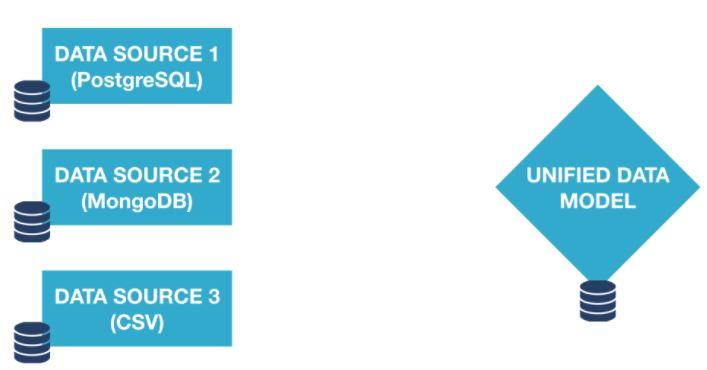

In [10]:
## hidden

#### Unified data model format

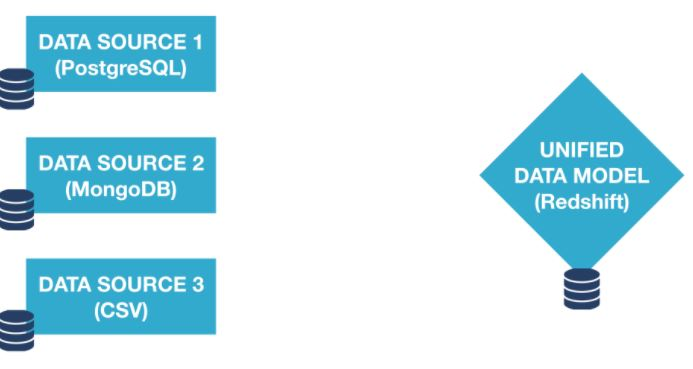

In [11]:
## For example, Unified data model : Redshift

**Example,**

- **`Data source 1` = `"Sales"`** stored as `PostgreSQL.file` is a `financial data`
- **`Data source 2` = `"Product"`** stored as `MongoDB.file` is a `behavioral data`
- **`Data source 3` = `"Marketing"`** stored as `csv.file` is a `contact data`

and

- **`Unified data model`** is `Redshift`

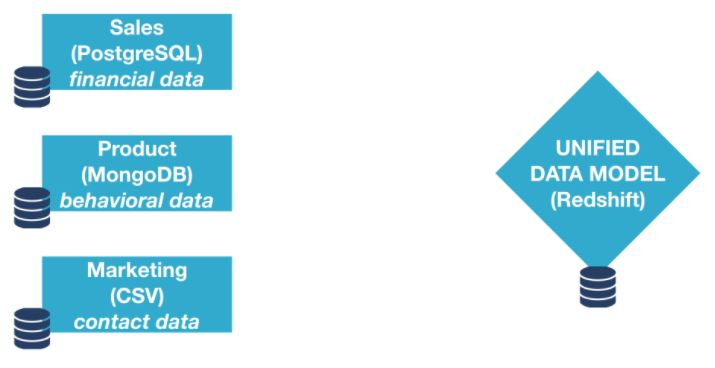

In [12]:
## hidden

Next, how to update?

**1. Update cadence from `sales` data**

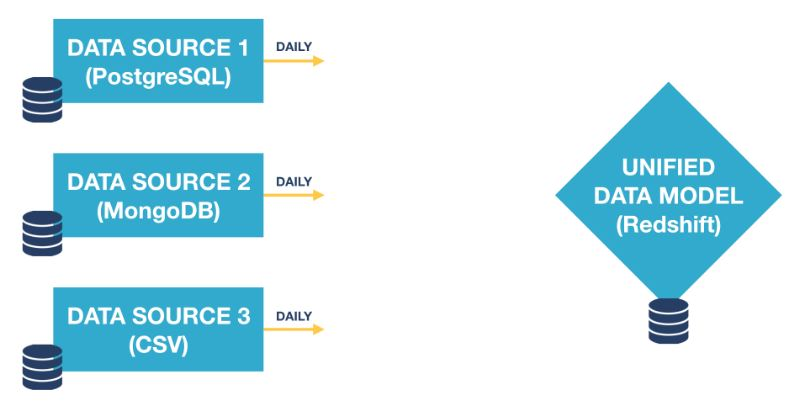

In [13]:
## hidden

**2. Update cadence - `air traffic`**. This is `real-time update`

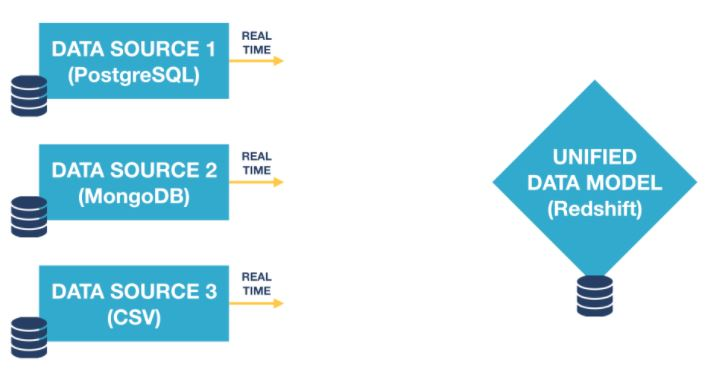

In [14]:
## hidden

**3. Different update cadency**

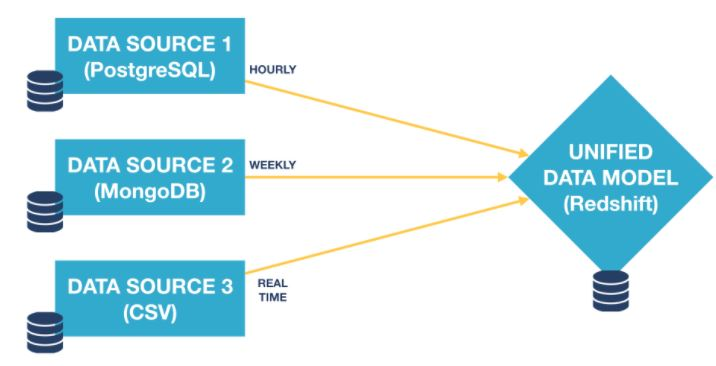

In [15]:
## hidden

But... it is not really good in some case since we are not sure about the different formats!

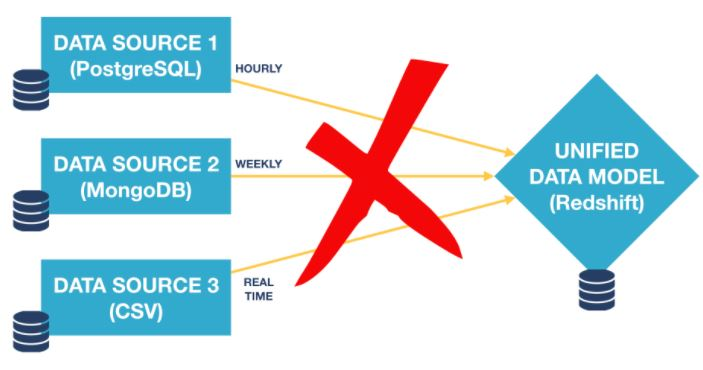

In [16]:
## hidden

To solve the `different format` problem; we will need the **`transformation`**

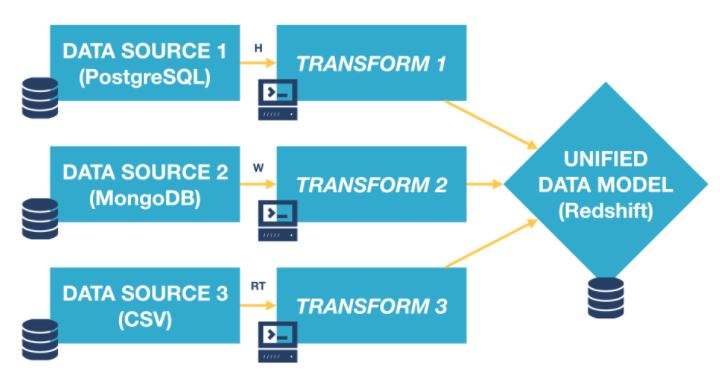

In [17]:
## hidden

Also, we can use **`tools`** when implementing the **`transformation`**

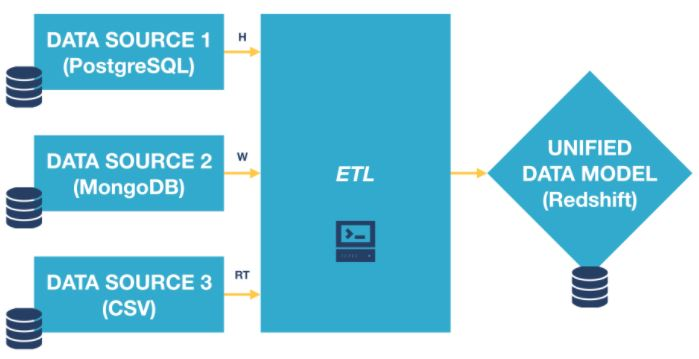

In [18]:
## hidden

#### REMARKs.

**Choosing a `data integration tools`** must be: **`flexible, realiable`** and **`scalable`**.

#### AUTOMATED TESTING & PROACTIVE ALERT

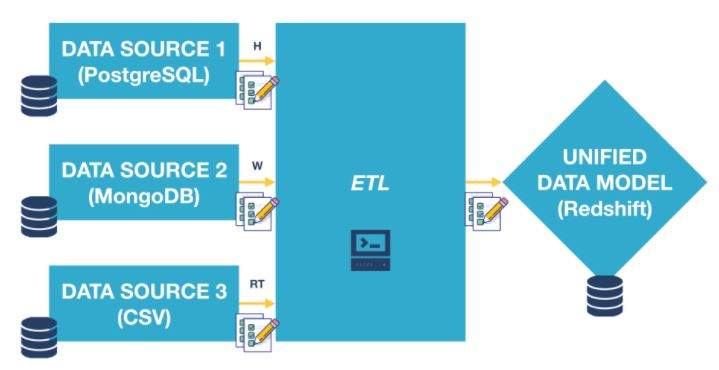

In [19]:
## hidden

**`Security`**

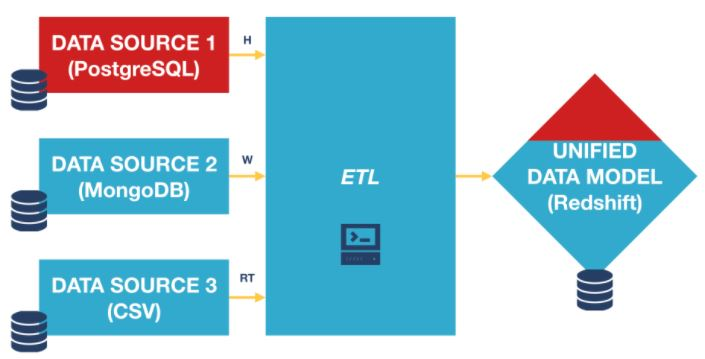

In [20]:
## hidden

**`Security`: credit cards & anonymization.**

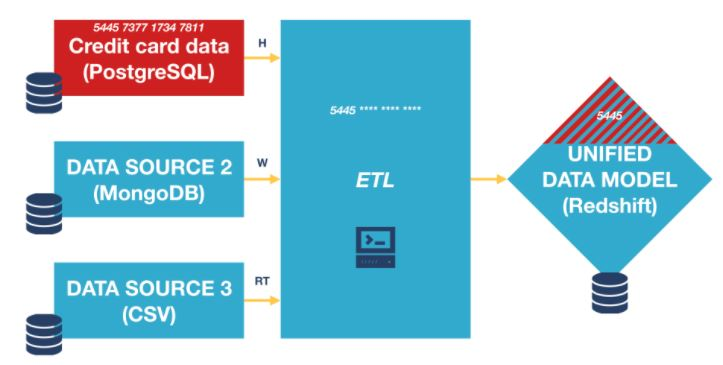

In [22]:
## hidden

**DATA GOVERNENCE. LINEAGE**

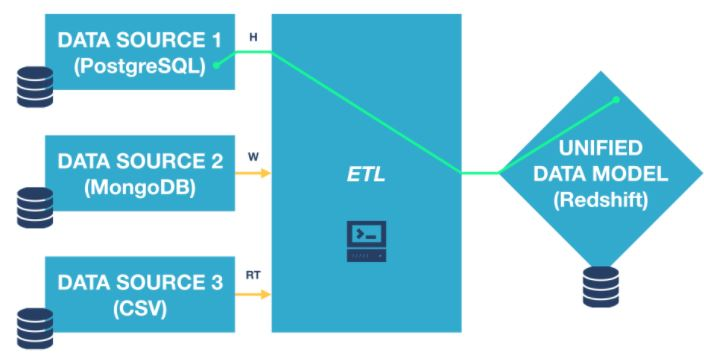

In [23]:
## hidden

### EXERCISEs

#### Exercise 3.1. `Data integration` do's and dont's
You just learned a lot about `data integration`, let's check your understanding of the concepts.

Categorize the following items as being True or False when talking about `data integration`!

**SOLUTION.**

| **`True`** | **`False`**|
|:-| :-|
| My `source data` can be in different **`format` & `database management system`**. | Everybody should to access `sensitive data` in the `final view`.|
| My `soucre data` can be **stored** in `any physical locations`. |  You should choose whichever solution for the job right now. |
| Data in the final view can be updated in `different intervals`. | `Automated testing & proactive alerts` **is not needed**. |
| You should be careful choosing a `hand-coded` because of ***maintance cost***| Your `data integration solution`, `handed code` or `ETL tool` **should work once** and then you can use the resulting view to **run `queries` forever**. |
| `Data integration` should be business driven, e.g., what combination of data will be useful for the business.| After `data integration` *all your data should be in a single* `table`.|
| Being able to access the `desired data` through a `single view` *doesn't mean all data is stored together*.| All your data should to be updated in `the real-time` in the `final view`|

#### Exercise 3.2. Analyzing a data integration plan
You're a `data analyst` in a hospital that wants to make sure there is enough `cough medicine` should an `epidemic break out`. 

For this, you need to combine the `historical health records` with the upcoming appointments to see if you can detect a pattern similar to the `last cold epidemic`. 

Then, you need to make sure there is `sufficient stock` available or if the stock should be increased. To help tackle this problem, you created a `data integration plan`.

Look at the following illustration!

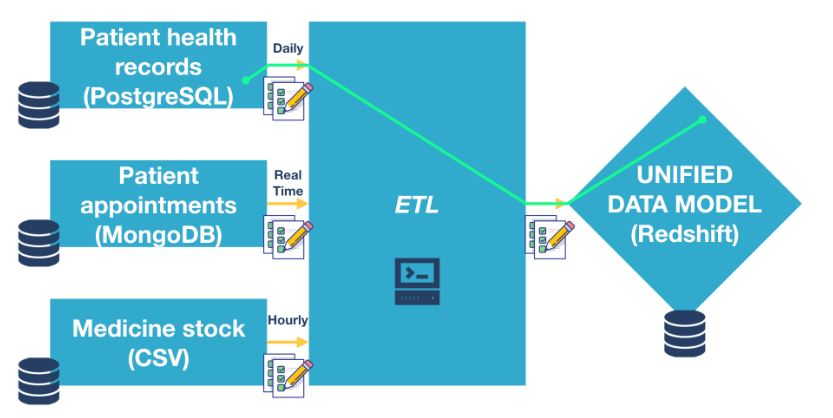

In [26]:
## hidden

**Question.** Which **`risk` is not clearly indicated on the `data integration` plan?**

A. It is unclear if you took `data governance` into account.

B. You didn't clearly show where your data originated from.

C. You should indicate that you plan to anonymize patient health records.

D. If data is lost during `ETL` you will not find out.

**Answer & comment!**

*A. Wrong!!* showing you thought about `lineage` is an `indicator` that you though about `data governance`!

*B. Incorrect!!* you know which `data sources` you are going to use and even indicated their `format`.

**C. Correct!!!** When working with `sensitive data` it is important to think about permissions. By `default` you should have the same `access rights` before and after `data integration`. If part of the data is `essential`, it should be `anonymized`, in this case you can keep the `illnesses` but `remove identifying information`.

*D. Wrong!* You've indicated that you test the data before and after `ETL`.

## 4. Picking a Database Management System (`DBMS`)

> **Uses.**  Create & maintain `database`, such as: `data`, `database schema` and `database engine`

> **Features.** Interface between `database` and `end users`

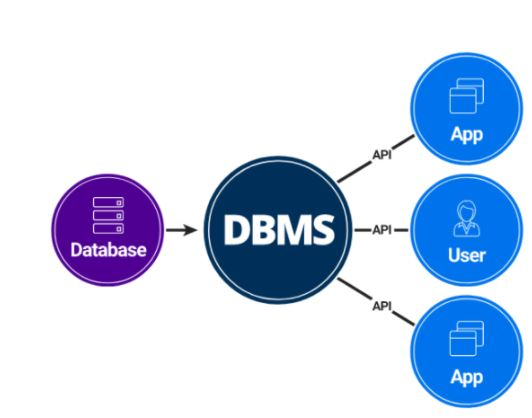

In [25]:
## hidden

#### DBSM types.
- Choices of `DBSM` depends on `database type`
- There are 2 types of `DBSM`: `SQL DBSM` and `NoSQL DBSM`

| **`SQL DBMS`**| **`NoSQL DBMS`** |
|:-|:-|
| Relational Database Management System (`RDBMS`) | Less structured |
| Based on the `relational model` of data | **`Document-centered`** *rather than* **`table centered`** |
| Query language: `SQL` | Data doesn't have to fit into well-defined rows and columns |
| Best option when: **`Data is structured and unchanging`** or **`Data must be consistent`**| Best option when: **`rapid growth`**, **`no clear schema definition`** and **`large quantities of data`**|
| | Types: `key-value store`, `document-store`, `columnar database` and `graph database` |

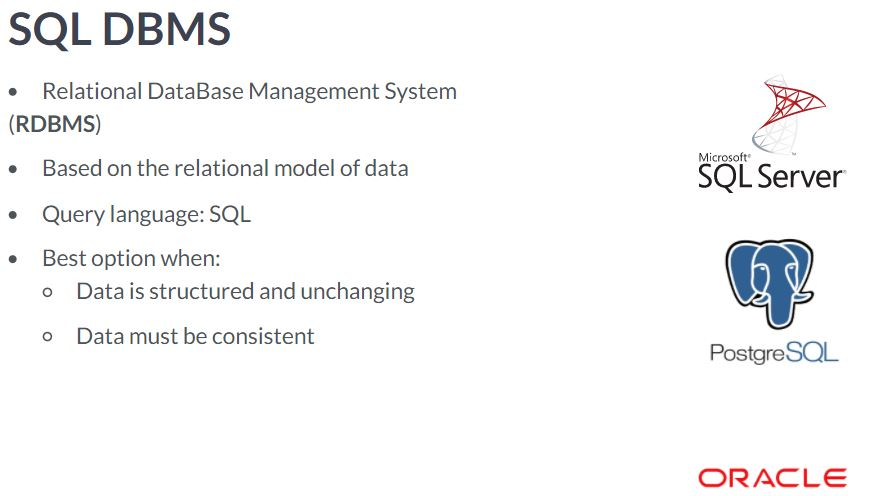

In [27]:
# hidden

### Types

#### 1. NoSQL DBMS; key-values stores

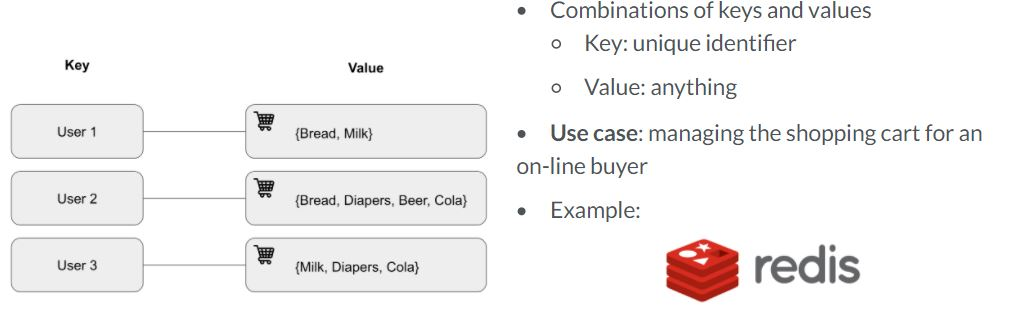

In [30]:
## hidden

#### 2. NoSQL DBMS; document store.

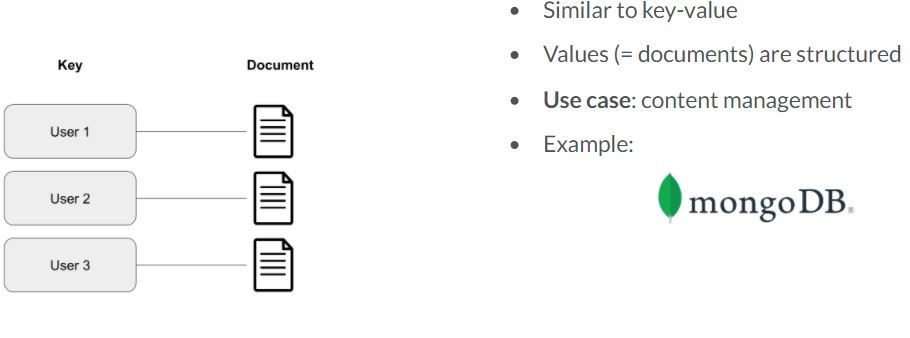

In [32]:
## hidden

#### 3. NoSQL DBMS; columnar database

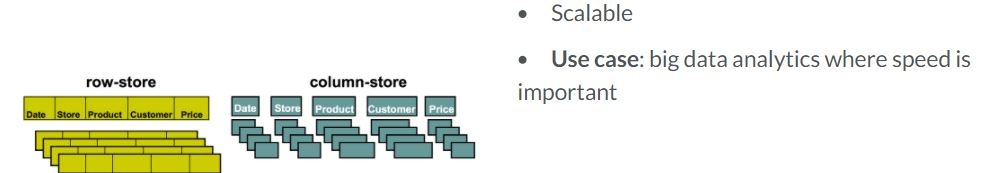

In [37]:
## hidden

#### 4. NoSQL DBMS; graph database

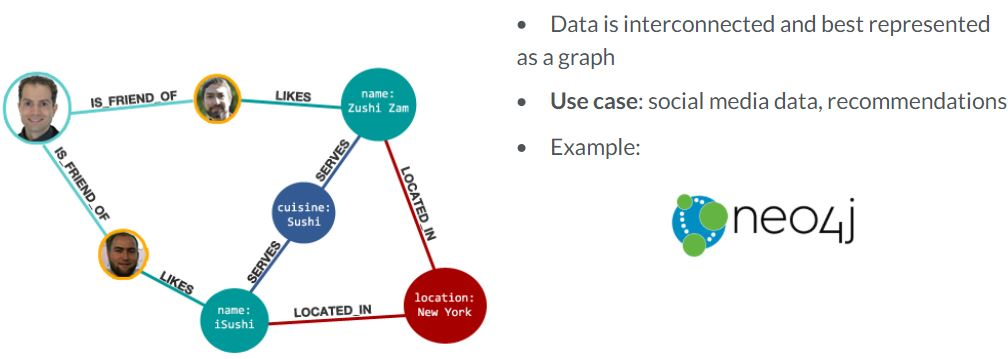

In [41]:
## hidden

#### CHOOSING DBMS

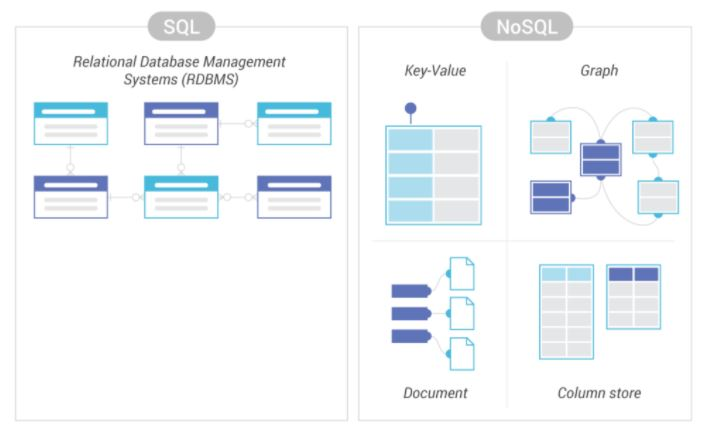

In [43]:
## hidden

### EXERCISEs
#### Exercise 4.1. SQL versus NoSQL
Deciding when to use a `SQL` versus `NoSQL DBMS` depends on the kind of information you’re storing and the best way to store it. Both types store data, they just store data differently.

When is it better to use a `SQL DBMS`?

A. You are dealing with rapidly evolving `features`, `functions`, `data types`, and it’s difficult to predict how the application will grow over time.

B. You have a lot of `data`, many different `data types`, and your data needs will only grow over time.

C. You are concerned about `data consistency` and 100% `data integrity` is your top goal.

D. Your data needs `scale up, out`, and `down`.

**Answer & comment!**

*A. Wrong!!* Changing a data model in `SQL DBMS`s is clunky and requires code changes which makes NoSQL DBMSs the better alternative.

*B. Incorrect!!* `NoSQL DBMS`s make it easy to store all `different types of data together` and *without having to invest time into defining what type of data you’re storing in advance*.

**C. Correct!!!** The strength of `SQL DBMSs` lies in using `integrity constraints` **to maintain `data consistency` across `multiple tables`**.

*D. Incorrect!* `NoSQL DBMSs` provide much greater flexibility and the ability to control costs as your data needs change.

#### Exercise 4.2. Choosing the right `DBMS`
As you saw in the video, there are lots of different options when choosing a `DBMS`. The choice depends on the business need. In this exercise, you are given a list of cards describing different scenarios and it's your job to pick the `DBMS` type that fits the project best. Remember the different `DBMS` types:

- `SQL: RDBMS`
- `NoSQL: key-value store, document store, columnar database, graph database`

Categorize the cards into the appropriate `DBMS` bucket!

**SOLUTION.**
    
    |                     SQL                               |                            NoSQL                            |
    |=======================================================|=============================================================|
    |   A banking application when it's extremely important |   During the holiday shopping season, an e-commerce website |
    | that data integrity is ensured                        | needs to keep track of millions of shopping carts.          |
    |                                                       |-------------------------------------------------------------|
    |                                                       |   A blog that need to create and incoperate new type of     |
    |                                                       | content; such as image, comment and video.                  |
    |                                                       |-------------------------------------------------------------|
    |                                                       |   Data warehosing in big data                               |
    |                                                       |-------------------------------------------------------------|
    |                                                       |   A social media tool that provides users with the          |
    |                                                       | opportunities to growth their network via connection.       |
    |-------------------------------------------------------|-------------------------------------------------------------|